In [1]:
import copy
import random
from collections import Counter
from typing import List, Iterable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import arff
from scipy.stats import mode
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from tqdm.notebook import tqdm
from umap.umap_ import UMAP

random.seed(0)

In [2]:
DATA_ROOT = '/Users/alv.popov/study/ml/data/OpenML/'
DATASET_COUNT = 300

datasets_info = pd.read_csv(DATA_ROOT + 'data.csv')
datasets = []
for dataset_info in datasets_info.itertuples():
    try:
        data, meta = arff.loadarff(f"{DATA_ROOT}data/{dataset_info.id}.arff")
    except Exception:
        continue

    if (dataset_info.target is None or
        dataset_info.target not in meta.names() or
        meta[dataset_info.target][0] != 'nominal'):
        continue

    is_numeric = np.asarray(meta.types()) == 'numeric'
    is_nominal = np.asarray(meta.types()) == 'nominal'
    if (not np.all(np.logical_or(is_numeric, is_nominal)) or
        np.all(is_numeric) or
        np.all(is_nominal)
    ):
        continue

    datasets.append({
        'data': data,
        'meta': meta,
        'target': dataset_info.target
    })
    if len(datasets) == DATASET_COUNT:
        break

datasets[0]['data']

array([(b'arched', b'yes', b'no', b'no', b'no', b'no', b'no', b'yes', 1., 4., b'round', b'lac_central', b'lacunar', b'stripped', b'vesicles', b'yes', b'yes', 5., b'malign_lymph'),
       (b'displaced', b'yes', b'no', b'no', b'yes', b'yes', b'no', b'yes', 1., 3., b'round', b'lac_central', b'lacunar', b'diluted', b'vesicles', b'yes', b'yes', 3., b'malign_lymph'),
       (b'deformed', b'no', b'no', b'no', b'yes', b'yes', b'yes', b'no', 3., 1., b'bean', b'lacunar', b'no', b'diluted', b'vesicles', b'no', b'no', 7., b'fibrosis'),
       (b'arched', b'no', b'no', b'no', b'no', b'yes', b'no', b'yes', 1., 2., b'oval', b'lac_margin', b'lac_margin', b'drop_like', b'vesicles', b'no', b'yes', 1., b'malign_lymph'),
       (b'arched', b'no', b'no', b'no', b'no', b'no', b'no', b'no', 1., 2., b'round', b'lac_margin', b'lac_margin', b'faint', b'vesicles', b'no', b'no', 1., b'metastases'),
       (b'arched', b'no', b'no', b'no', b'no', b'no', b'no', b'yes', 1., 2., b'oval', b'lac_central', b'lacunar', b'

In [3]:
# базовые мета-признаки -> число объектов, признаков
def height(dataset) -> int:
    return len(dataset['data'])

def width(dataset) -> int:
    return len(dataset['meta'].names())

def categories_count(dataset) -> int:
    return np.count_nonzero(np.asarray(dataset['meta'].types()) == 'nominal')

# числа нормализуем, категории превращаем в массив вероятностей
# берем min/max -> среднее
def normalize(col: np.ndarray) -> np.ndarray:
    centered = col - np.nanmean(col)
    return centered if np.isclose(0, np.nanstd(col)) else centered / np.nanstd(col)

def one_hot(categories: Iterable, col: np.ndarray) -> List:
    cols = []
    for category in categories:
        cols.append([int(v == category) for v in col])
    return cols

def calc_stat(dataset, feature_type, f1, f2):
    if feature_type != 'numeric' and feature_type != 'nominal':
        raise ValueError("Invalid feature type")

    stat = []
    for i, feature_name in enumerate(dataset['meta']):
        col = dataset['data'][feature_name]
        feature = dataset['meta'][feature_name]
        if feature[0] == feature_type:
            stat.append(f1(col))
    return f2(stat) if len(stat) > 0 else None

def min_numeric(dataset):
    return calc_stat(dataset, 'numeric', lambda col: np.nanmin(normalize(col)), np.nanmean)

def max_numeric(dataset):
    return calc_stat(dataset, 'numeric', lambda col: np.nanmax(normalize(col)), np.nanmean)

def min_nominal_prob(dataset):
    return calc_stat(dataset, 'nominal', lambda col: min(dict(Counter(col)).values()) / len(col), np.mean)

def max_nominal_prob(dataset):
    return calc_stat(dataset, 'nominal', lambda col: max(dict(Counter(col)).values()) / len(col), np.mean)

# количество значений целевой переменной
def unique_targets(dataset) -> int:
    return len(dataset['meta'][dataset['target']][1])

def get_xy(dataset) -> tuple[np.ndarray, np.ndarray]:
    if 'xy' in dataset:
        return dataset['xy']

    x, y = [], None
    for feature_name in dataset['meta']:

        feature_meta = dataset['meta'][feature_name]
        if feature_meta[0] == 'numeric':
            col = pd.Series(normalize(dataset['data'][feature_name]))
            col = col.fillna(col.mean()).to_numpy()
            x.append(col)
        else:
            col = pd.Series(dataset['data'][feature_name])
            col = col.fillna(col.mode()[0]).to_numpy()

            if feature_name == dataset['target']:
                y = col
            else:
                categories_bin = map(lambda c: c.encode('utf-8'), feature_meta[1])
                x.append(one_hot(categories_bin, col)[0])

    if y is None:
        raise ValueError(dataset['meta'])

    dataset['xy'] = np.asarray(x).T, y

    return dataset['xy']

# дерево решений -> максимальная глубина
def max_depth(dataset) -> int:
    x, y = get_xy(dataset)
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(x, y)
    return clf.get_depth()

# коэффициенты линейной модели -> среднее + среднее
def mean_linear_coeff(dataset):
    x, y = get_xy(dataset)
    reg = LogisticRegression(random_state=0, max_iter=200)
    reg.fit(x, y)
    return np.mean(reg.coef_)

funcs = [
    height,
    width,
    categories_count,
    min_numeric,
    max_numeric,
    min_nominal_prob,
    max_nominal_prob,
    max_depth,
    mean_linear_coeff
]

for func in funcs:
    print(f'{func.__name__}: {func(datasets[0])}')

height: 148
width: 19
categories_count: 16
min_numeric: -0.9348776576678107
max_numeric: 3.6268121584064303
min_nominal_prob: 0.16554054054054057
max_nominal_prob: 0.6169763513513513
max_depth: 11
mean_linear_coeff: 2.4671622769447922e-17


In [4]:
# от порядка строк/столбцов/категорий метапризнаки не меняются
original_dataset = datasets[0]
changed_dataset = copy.deepcopy(original_dataset)
target_values = changed_dataset['meta'][changed_dataset['target']][1]
target2ind = {v.encode('utf-8'): i for i, v in zip(range(15, 15 + len(target_values)), target_values)}
changed_dataset['data'][changed_dataset['target']] = np.vectorize(lambda b: target2ind[b])(changed_dataset['data'][changed_dataset['target']])
np.random.shuffle(changed_dataset['data'])
np.random.shuffle(changed_dataset['data'].T)

for func in funcs:
    assert np.isclose(func(original_dataset), func(changed_dataset))
print('done')

done


In [5]:
meta_dataset = pd.DataFrame({
    func.__name__: [
        func(dataset) for dataset in datasets
    ] for func in funcs
})

In [6]:
models = [
    ('svc', SVC),
    ('random_forest', RandomForestClassifier),
    ('gradient_boosting', GradientBoostingClassifier)
]

def kfold(x, y, model) -> float:
    score = []
    for train_index, test_index in KFold(random_state=0, shuffle=True).split(x, y):
        model.fit(x[train_index], y[train_index])
        y_pred = model.predict(x[test_index])
        score.append(accuracy_score(y[test_index], y_pred))
    return np.mean(score)

def get_score(x, y, model) -> float:
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return accuracy_score(y_test, y_pred)

def get_best_model(dataset) -> str:
    results = []
    x, y = get_xy(dataset)
    for name, model in models:
        results.append((kfold(x, y, model(random_state=0)), name))
    return max(results, key=lambda x: x[0])[1]

meta_dataset['model'] = [get_best_model(dataset) for dataset in tqdm(datasets)]
meta_dataset

  0%|          | 0/300 [00:00<?, ?it/s]

,height,width,categories_count,min_numeric,max_numeric,min_nominal_prob,max_nominal_prob,max_depth,mean_linear_coeff,model
0,148,19,16,-0.934878,3.626812,0.165541,0.616976,11,2.467162e-17,svc
1,214,10,1,-1.968487,4.832826,0.355140,0.644860,10,-2.475235e-01,gradient_boosting
2,148,19,16,-0.934878,3.626812,0.192990,0.616976,11,-2.837156e-01,svc
3,107,13,10,-1.594198,3.035985,0.068224,0.506542,11,-5.415209e-01,random_forest
4,63,32,5,-1.277364,3.529887,0.269841,0.396825,6,-7.405965e-02,svc
...,...,...,...,...,...,...,...,...,...,...
295,87,11,3,-2.665234,2.345240,0.406130,0.593870,8,-3.700526e-01,random_forest
296,250,11,1,-1.845884,2.203507,0.468000,0.532000,8,-6.289213e-02,random_forest
297,60,8,2,-2.954480,1.787283,0.475000,0.525000,8,-3.396893e-01,random_forest
298,100,4,3,-1.155026,1.124631,0.030000,0.496667,6,-3.071355e-01,svc


In [7]:
Counter(meta_dataset.model)

Counter({'svc': 131, 'gradient_boosting': 76, 'random_forest': 93})

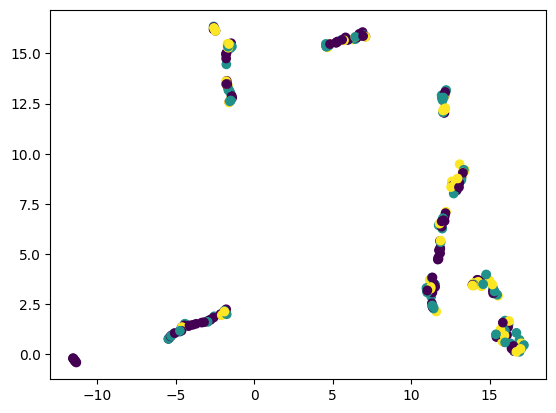

In [8]:
x = meta_dataset.drop('model', axis=1)
embedding = UMAP(random_state=0).fit_transform(x)

color_mapper = {
    'svc': 0,
    'random_forest': 1,
    'gradient_boosting': 2
}

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[color_mapper[model] for model in meta_dataset.model]
)
plt.show()

In [9]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import SGDClassifier

# наивный - возьмем алгоритм с лучшей точностью
class Naive:
    best = None

    def fit(self, _, y):
        self.best = mode(y).mode[0]

    def predict(self, x):
        return [self.best for _ in range(len(x))]

x, y = meta_dataset.drop('model', axis=1).to_numpy(), meta_dataset.model.to_numpy()
print("--- Accuracy ---")
print("Naive: ", kfold(x, y, Naive()))
print("BernoulliNB: ", kfold(x, y, BernoulliNB()))
print("SVC: ", kfold(x, y, SVC()))

--- Accuracy ---
Naive:  0.43666666666666665
BernoulliNB:  0.43666666666666665
SVC:  0.43666666666666665
